In [1]:
import matplotlib
import matplotlib.pyplot as plt
import json
import pickle
import numpy as np
import nltk
from evaluate import bleu, cider, meteor, rouge, spice

In [2]:
with open('data/val.json', 'r') as f:
    captions = json.load(f)

In [3]:
# check where there is at least one image with bad quality:
count = 0
precanned = []
img_ids_precanned =[]
img_files_precanned = []

for i, cap in enumerate(captions['annotations']):
    if cap['is_precanned'] == True:
        count +=1
        precanned.append(i) 
        idx = captions['annotations'][i]['image_id']
        if idx not in img_ids_precanned:
            img_ids_precanned.append(captions['annotations'][i]['image_id']) 
            idx = captions['annotations'][i]['image_id'] - 23431
            filename = captions['images'][idx]['file_name']
            img_files_precanned.append(filename)
            

### Train vs Validation loss for 2-Layer LSTM w/t attention

In [4]:
# load results 
loss_val = np.load('output/loss_val2.npy')
loss_train = np.load('output/loss_train2.npy')

# from iterations to epochs (10 epochs):
loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -10:], axis=1)


Text(0.5, 1.0, 'Loss vs iterations')

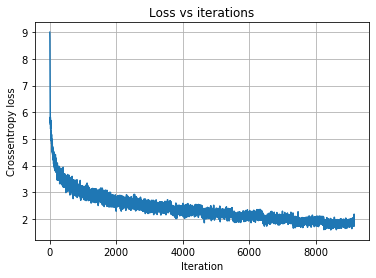

In [98]:
# plot training loss vs iterations:
plt.plot(range(len(loss_train)), loss_train)
plt.grid()
plt.ylabel('Crossentropy loss')
plt.xlabel('Iteration')
plt.title('Loss vs iterations')

Text(0.5, 1.0, 'Loss vs iterations')

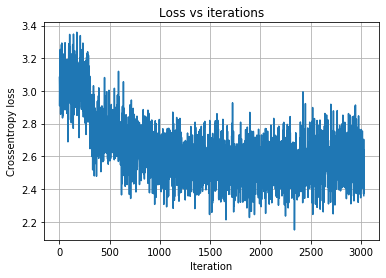

In [99]:
#plot validation loss vs iterations:
plt.plot(range(len(loss_val)), loss_val)
plt.grid()
plt.ylabel('Crossentropy loss')
plt.xlabel('Iteration')
plt.title('Loss vs iterations')

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

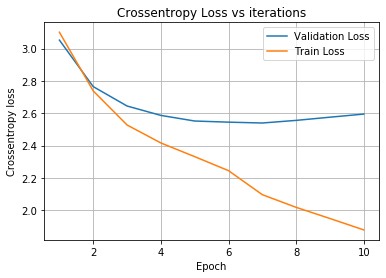

In [100]:
# plot average train and validation loss per epoch 
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_train_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

In [34]:
print('Validation scores for Coco on VizWiz trained model (4th epoch):')
%run evaluate.py --target_path 'data/captions_val2017.json' --predict_path 'output/predict2_val_coco.json'

Validation scores for Coco on VizWiz trained model (4th epoch):
Namespace(predict_path='output/predict2_val_coco.json', target_path='data/captions_val2017.json')
{'testlen': 57607, 'reflen': 53584, 'guess': [57607, 52607, 47607, 42607], 'correct': [20459, 5112, 824, 186]}
ratio: 1.0750783816064298
bleu = [0.3551478118978535, 0.1857711314238878, 0.08421787577771878, 0.04018474430737628]
cider = 0.06870578631146286
rouge = 0.24207431389527936


In [27]:
with open('output/predict2_val_6e.json') as f:
    pred1_4 = json.load(f)

# bad quality image predicted (find all images that are predicted as bad quality by the model ):
#if caption is predicted as '<start> quality issues are too severe to recognize visual content . <end>'
pred_precanned = [k for k,v in pred1_4.items() if v == '<start> quality issues are too severe to recognize visual content . <end>']
count_correct = 0
count_wrong = 0
for filename in pred_precanned:
    if filename in  img_files_precanned:
        count_correct +=1
    else: 
        count_wrong +=1        
print(count_correct, count_wrong) 

912 101


### Train vs Validation loss for 1-Layer LSTM w/t attention

In [92]:
loss_val = np.load('output/loss_val1.npy')
loss_train = np.load('output/loss_train1.npy')


loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -10:], axis=1)


with open('output/results1.json', 'r') as f:
    results = json.load(f)

Text(0.5, 1.0, 'Loss vs iterations')

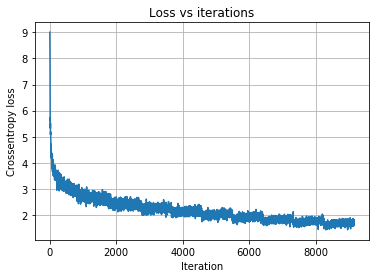

In [93]:
plt.plot(range(len(loss_train)), loss_train)
plt.grid()
plt.ylabel('Crossentropy loss')
plt.xlabel('Iteration')
plt.title('Loss vs iterations')

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

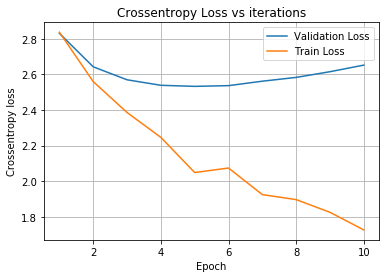

In [94]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

"\nplt.bar(range(1, len(loss_epoch)+1), results['rouge'])\nplt.bar(range(1, len(loss_epoch)+1), results['cider'])\nplt.bar(range(1, len(loss_epoch)+1), [w[0] for w in results['bleu']])\nplt.bar(range(1, len(loss_epoch)+1), [w[1] for w in results['bleu']])\nplt.bar(range(1, len(loss_epoch)+1), [w[2] for w in results['bleu']])\nplt.bar(range(1, len(loss_epoch)+1), [w[3] for w in results['bleu']])\n"

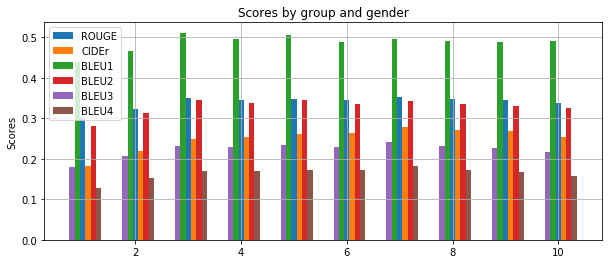

In [95]:
x = np.arange(len(loss_val_per_epoch)) +1 # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(x, results['rouge'], width, label='ROUGE')
rects2 = ax.bar(x + width, results['cider'], width, label='CIDEr')
rects3 = ax.bar(x - width, [w[0] for w in results['bleu']], width, label='BLEU1')
rects4 = ax.bar(x + 2*width, [w[1] for w in results['bleu']], width, label='BLEU2')
rects5 = ax.bar(x - 2*width, [w[2] for w in results['bleu']], width, label='BLEU3')
rects6 = ax.bar(x + 3*width, [w[3] for w in results['bleu']], width, label='BLEU4')


ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()
ax.grid()


In [29]:
print('Validation scores for VizWiz on Coco pretrained model:')
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predict_val_pretrained.json' 

Validation scores for VizWiz on Coco pretrained model
Namespace(predict_path='output/predict_val_pretrained.json', target_path='data/val.json')
{'testlen': 77540, 'reflen': 76550, 'guess': [77540, 69790, 62040, 54290], 'correct': [29040, 7937, 1461, 327]}
ratio: 1.01293272370998
bleu = [0.374516378643276, 0.20637971038535377, 0.10010078302652241, 0.04957755257781647]
cider = 0.060966622020708114
rouge = 0.24219359822358233


In [30]:
print('Validation scores for Coco on Coco pretrained model:')
%run evaluate.py --target_path 'data/captions_val2017.json' --predict_path 'output/predict_val_pretrained_coco.json'

Validation scores for Coco on Coco pretrained model
Namespace(predict_path='output/predict_val_pretrained_coco.json', target_path='data/captions_val2017.json')
{'testlen': 49560, 'reflen': 48811, 'guess': [49560, 44560, 39560, 34560], 'correct': [26885, 11133, 4092, 1426]}
ratio: 1.015344901763926
bleu = [0.5424737691686735, 0.3681483725897151, 0.2411247020686879, 0.15508426137535666]
cider = 0.41190482581026755
rouge = 0.36621429225987473


In [32]:
print('Validation scores for Coco on VizWiz trained model (4th epoch):')
%run evaluate.py --target_path 'data/captions_val2017.json' --predict_path 'output/predict_val_coco.json'

Validation scores for Coco on VizWiz trained model (4th epoch):
Namespace(predict_path='output/predict_val_coco.json', target_path='data/captions_val2017.json')
{'testlen': 58357, 'reflen': 53868, 'guess': [58357, 53357, 48357, 43357], 'correct': [20642, 5097, 835, 205]}
ratio: 1.0833333333333133
bleu = [0.35371934815017303, 0.18381926409711213, 0.08356089005158909, 0.040754535917729005]
cider = 0.07748162496363897
rouge = 0.23802503847154188


In [25]:
with open('1layerold/output/predicted1_4.json') as f:
    pred1_4 = json.load(f)

# bad quality image predicted (find all images that are predicted as bad quality by the model ):
#if caption is predicted as '<start> quality issues are too severe to recognize visual content . <end>'
pred_precanned = [k for k,v in pred1_4.items() if v == '<start> quality issues are too severe to recognize visual content . <end>']
count_correct = 0
count_wrong = 0
for filename in pred_precanned:
    if filename in  img_files_precanned:
        count_correct +=1
    else: 
        count_wrong +=1
print(count_correct, count_wrong)   

938 83


### Train vs Validation loss LSTM with attention

In [21]:
loss_val = np.load('output/loss_att_val.npy')
loss_train = np.load('output/loss_att_train.npy')


loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -100:], axis=1)

with open('output/results_att.json', 'r') as f:
    results = json.load(f)

Text(0.5, 1.0, 'Loss vs iterations')

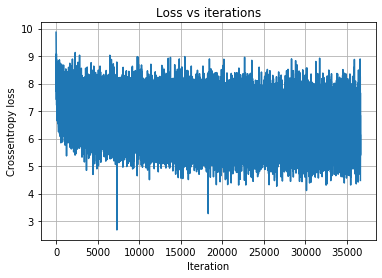

In [22]:
plt.plot(range(len(loss_train)), loss_train)
plt.grid()
plt.ylabel('Crossentropy loss')
plt.xlabel('Iteration')
plt.title('Loss vs iterations')

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

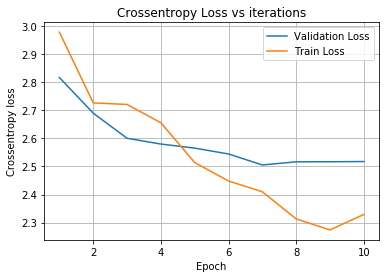

In [23]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch-4)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch-4)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

"\nplt.bar(range(1, len(loss_epoch)+1), results['rouge'])\nplt.bar(range(1, len(loss_epoch)+1), results['cider'])\nplt.bar(range(1, len(loss_epoch)+1), [w[0] for w in results['bleu']])\nplt.bar(range(1, len(loss_epoch)+1), [w[1] for w in results['bleu']])\nplt.bar(range(1, len(loss_epoch)+1), [w[2] for w in results['bleu']])\nplt.bar(range(1, len(loss_epoch)+1), [w[3] for w in results['bleu']])\n"

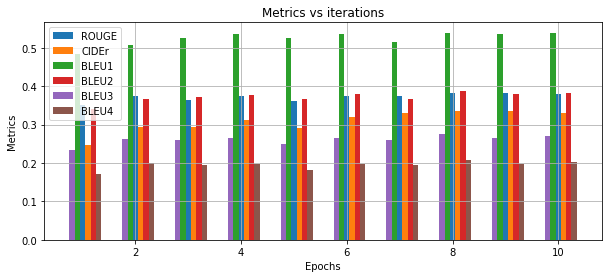

In [9]:
x = np.arange(len(loss_val_per_epoch)) +1 # the label locations
width = 0.1  # the width of the bars
#labels = ['ROUGE', 'CIDEr', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']

fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(x, results['rouge'], width, label='ROUGE')
rects2 = ax.bar(x + width, results['cider'], width, label='CIDEr')
rects3 = ax.bar(x - width, [w[0] for w in results['bleu']], width, label='BLEU1')
rects4 = ax.bar(x + 2*width, [w[1] for w in results['bleu']], width, label='BLEU2')
rects5 = ax.bar(x - 2*width, [w[2] for w in results['bleu']], width, label='BLEU3')
rects6 = ax.bar(x + 3*width, [w[3] for w in results['bleu']], width, label='BLEU4')


ax.set_ylabel('Metrics')
ax.set_xlabel('Epochs')
ax.set_title('Metrics vs iterations')
ax.legend()
ax.grid()


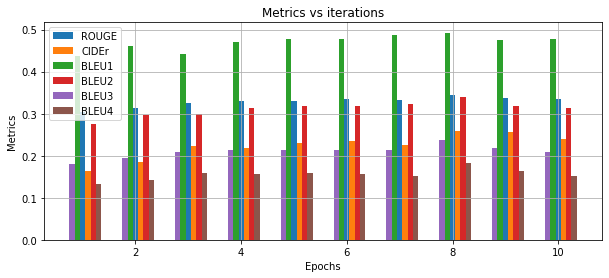

In [49]:
with open('output/results_att_lr2.json', 'r') as f:
    results = json.load(f)
    
x = np.arange(len(loss_val_per_epoch)) +1 # the label locations
width = 0.1  # the width of the bars
#labels = ['ROUGE', 'CIDEr', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']
fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(x, results['rouge'], width, label='ROUGE')
rects2 = ax.bar(x + width, results['cider'], width, label='CIDEr')
rects3 = ax.bar(x - width, [w[0] for w in results['bleu']], width, label='BLEU1')
rects4 = ax.bar(x + 2*width, [w[1] for w in results['bleu']], width, label='BLEU2')
rects5 = ax.bar(x - 2*width, [w[2] for w in results['bleu']], width, label='BLEU3')
rects6 = ax.bar(x + 3*width, [w[3] for w in results['bleu']], width, label='BLEU4')


ax.set_ylabel('Metrics')
ax.set_xlabel('Epochs')
ax.set_title('Metrics vs iterations')
ax.legend()
ax.grid()

In [80]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predicted_att_8.json'

Namespace(predict_path='output2/predicted_att_8.json', target_path='data/val.json')
{'testlen': 79404, 'reflen': 78016, 'guess': [79404, 71654, 63904, 56154], 'correct': [42776, 19838, 8901, 5083]}
ratio: 1.0177912223133585
bleu = [0.538713414941306, 0.3861958641050299, 0.2749003745676378, 0.2082410532539355]
cider = 0.3346322486761859
rouge = 0.3824037113001658


In [ ]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predicted_att_8.json'

In [39]:
%run evaluate.py --target_path 'data/captions_val2017.json' --predict_path 'output/predict_val_coco_att.json'

Namespace(predict_path='output/predict_val_coco_att.json', target_path='data/captions_val2017.json')
{'testlen': 49533, 'reflen': 48987, 'guess': [49533, 44533, 39533, 34533], 'correct': [12922, 1902, 192, 30]}
ratio: 1.0111458141955822
bleu = [0.260876587325616, 0.10555573453636079, 0.03782408001359466, 0.014724752940539773]
cider = 0.017818035200480684
rouge = 0.1764415061059854


In [57]:
%run evaluate.py --target_path 'data/captions_val2017.json' --predict_path 'output/predict_val_coco_tr.json'

Namespace(predict_path='output/predict_val_coco_tr.json', target_path='data/captions_val2017.json')
{'testlen': 60039, 'reflen': 54642, 'guess': [60039, 55039, 50039, 45039], 'correct': [19575, 4494, 585, 105]}
ratio: 1.0987701767870668
bleu = [0.32603807525108136, 0.1631606500949014, 0.06776821284026566, 0.029185669788602823]
cider = 0.04575488810595381
rouge = 0.23173606986963027


In [54]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predicted_att_10.json'

Namespace(predict_path='output/predicted_att_10.json', target_path='data/val.json')
{'testlen': 80204, 'reflen': 78536, 'guess': [80204, 72454, 64704, 56954], 'correct': [43239, 19600, 8661, 4862]}
ratio: 1.0212386676173852
bleu = [0.5391127624557311, 0.3818885689175872, 0.2692589051530511, 0.20204599099050097]
cider = 0.3305200293200122
rouge = 0.3808065048571612


In [77]:
with open('output2/predicted_att_8.json') as f:
    pred = json.load(f)

# bad quality image predicted:
pred_precanned = [k for k,v in pred.items() if v == '<start> quality issues are too severe to recognize visual content . <end>']
count_correct = 0
count_wrong = 0
for filename in pred_precanned:
    if filename in  img_files_precanned:
        count_correct +=1
    else: 
        count_wrong +=1
print(count_correct, count_wrong)  

952 85


In [56]:
print('Metrics for  LSTM with attention with beam search')
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predict_beam_att_8.json'

Metrics for  LSTM with attention with beam search
Namespace(predict_path='output/predict_beam_att_8.json', target_path='data/val.json')
{'testlen': 75782, 'reflen': 74864, 'guess': [75782, 68033, 60284, 52535], 'correct': [36671, 21397, 13166, 9084]}
ratio: 1.0122622355203967
bleu = [0.48390119025625494, 0.39011709127500266, 0.3215243839818191, 0.27533887484037844]
cider = 0.35423940895113853
rouge = 0.39126966728686113


### Train vs Validation loss LSTM with attention with frozen layers

In [27]:
loss_val = np.load('output/loss_val_att_ft.npy')
loss_train = np.load('output/loss_train_att_ft.npy')


loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -100:], axis=1)

with open('output/results_att.json', 'r') as f:
    results = json.load(f)

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

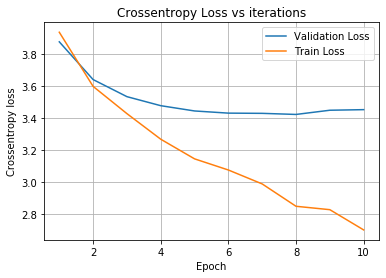

In [29]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

In [31]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predicted_att_ft_8.json'

Namespace(predict_path='output/predicted_att_ft_8.json', target_path='data/val.json')
{'testlen': 78587, 'reflen': 77687, 'guess': [78587, 70837, 63087, 55337], 'correct': [42866, 20006, 9500, 5488]}
ratio: 1.0115849498628984
bleu = [0.5454591726366886, 0.39249233230887715, 0.28519945706140126, 0.21900858727147426]
cider = 0.3472001739067661
rouge = 0.3865431136282979


### Train vs Validation loss LSTM with imcreased learning rate

In [33]:
loss_val = np.load('output/loss_att_val_lr2.npy')
loss_train = np.load('output/loss_att_train_lr2.npy')


loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -100:], axis=1)

with open('output/results_att.json', 'r') as f:
    results = json.load(f)

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

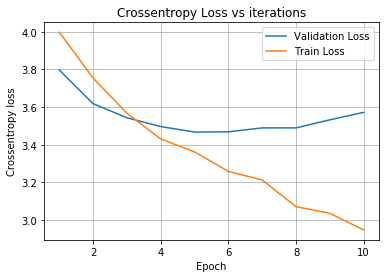

In [34]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

In [36]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predicted_att2_lr25.json'

Namespace(predict_path='output/predicted_att2_lr25.json', target_path='data/val.json')
{'testlen': 79355, 'reflen': 78089, 'guess': [79355, 71605, 63855, 56105], 'correct': [37906, 15078, 6267, 3605]}
ratio: 1.016212270614286
bleu = [0.4776762648856344, 0.31715168718030506, 0.21451925459434543, 0.15869952796805847]
cider = 0.22973854440476912
rouge = 0.3294368251442894


### Train vs Validation loss Transformer lr= 0.0001

In [52]:
loss_val = np.load('output/loss_val_tr.npy')
loss_train = np.load('output/loss_train_tr.npy')

loss_val2 = np.load('output/loss_val_11tr.npy')
loss_train2 = np.load('output/loss_train_temp_tr.npy')


loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -100:], axis=1)

loss_val_per_epoch2 = np.mean(loss_val2.reshape(7, len(loss_val2)//7), axis=1)
loss_train_per_epoch2 = np.mean(loss_train2.reshape(7, len(loss_train2)//7)[:, -100:], axis=1)


loss_val_per_epoch  = np.concatenate((loss_val_per_epoch, loss_val_per_epoch2), axis=0)
loss_train_per_epoch  = np.concatenate((loss_train_per_epoch, loss_train_per_epoch2), axis=0)


with open('output/results_tr.json', 'r') as f:
    results = json.load(f)

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

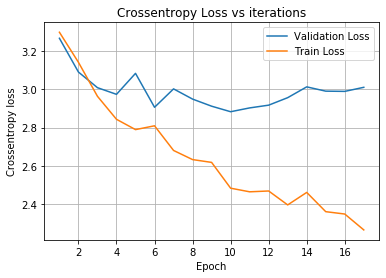

In [53]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

In [69]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output/predicted_tr_6.json'

Namespace(predict_path='output/predicted_tr_6.json', target_path='data/val.json')
{'testlen': 87035, 'reflen': 83018, 'guess': [87035, 79285, 71535, 63785], 'correct': [42224, 18201, 8070, 4750]}
ratio: 1.0483870967741808
bleu = [0.4851381628080601, 0.3337219934889713, 0.23247425816262415, 0.17489400190268148]
cider = 0.27417006154636797
rouge = 0.35865055072085833


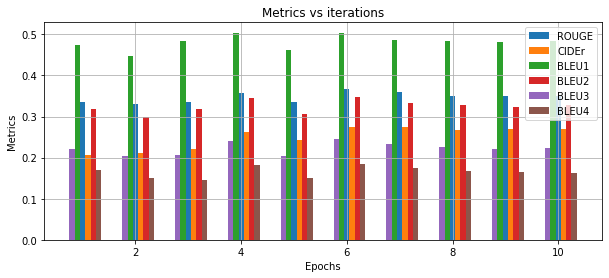

In [67]:
with open('output/results_tr.json', 'r') as f:
    results = json.load(f)
    
x = np.arange(len(loss_val_per_epoch)) +1 # the label locations
width = 0.1  # the width of the bars
#labels = ['ROUGE', 'CIDEr', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']
fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(x, results['rouge'], width, label='ROUGE')
rects2 = ax.bar(x + width, results['cider'], width, label='CIDEr')
rects3 = ax.bar(x - width, [w[0] for w in results['bleu']], width, label='BLEU1')
rects4 = ax.bar(x + 2*width, [w[1] for w in results['bleu']], width, label='BLEU2')
rects5 = ax.bar(x - 2*width, [w[2] for w in results['bleu']], width, label='BLEU3')
rects6 = ax.bar(x + 3*width, [w[3] for w in results['bleu']], width, label='BLEU4')


ax.set_ylabel('Metrics')
ax.set_xlabel('Epochs')
ax.set_title('Metrics vs iterations')
ax.legend()
ax.grid()

### Train vs Validation loss Transformer lr1= 0.00001, lr2 = 0.0004

In [70]:
loss_val = np.load('output_tr_2/loss_val_tr.npy')
loss_train = np.load('output_tr_2/loss_train_tr.npy')


loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -100:], axis=1)

with open('output_tr_2/results_tr.json', 'r') as f:
    results = json.load(f)

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

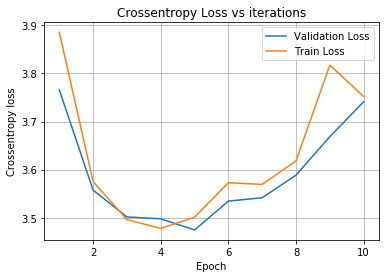

In [71]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

In [73]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output_tr_2/predicted_tr_5.json'

Namespace(predict_path='output_tr_2/predicted_tr_5.json', target_path='data/val.json')
{'testlen': 91132, 'reflen': 85761, 'guess': [91132, 83382, 75632, 67882], 'correct': [36982, 16128, 7068, 4160]}
ratio: 1.0626275346602643
bleu = [0.40580696133081234, 0.2801649808539336, 0.19430003783715732, 0.14560937548113703]
cider = 0.25206980562703424
rouge = 0.32750779995782847


In [81]:
loss_val = np.load('output/loss_val_11tr.npy')
loss_train = np.load('output/loss_train_temp_tr.npy')


loss_val_per_epoch = np.mean(loss_val.reshape(7, len(loss_val)//7), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(7, len(loss_train)//7)[:, -100:], axis=1)

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

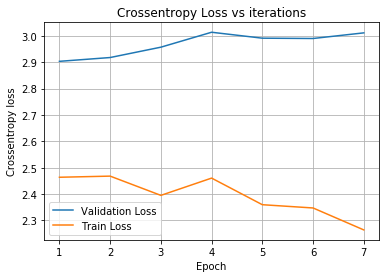

In [80]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

In [47]:
loss_val = np.load('output/loss_valtr3.npy')
loss_train = np.load('output/loss_traintr3.npy')

loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -100:], axis=1)


loss_val2 = np.load('output_tr_3/loss_val11tr3.npy')
loss_train2 = np.load('output_tr_3/loss_train11tr3.npy')
loss_val_per_epoch2 = np.mean(loss_val2.reshape(10, len(loss_val2)//10), axis=1)
loss_train_per_epoch2 = np.mean(loss_train2.reshape(10, len(loss_train2)//10)[:, -100:], axis=1)


loss_val_per_epoch  = np.concatenate((loss_val_per_epoch, loss_val_per_epoch2), axis=0)
loss_train_per_epoch  = np.concatenate((loss_train_per_epoch, loss_train_per_epoch2), axis=0)

with open('output/resultstr3.json', 'r') as f:
    results = json.load(f)

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

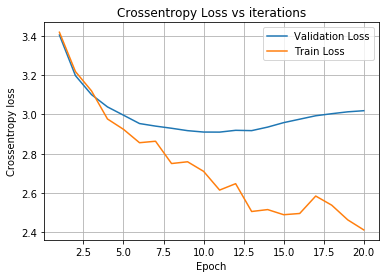

In [48]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

In [45]:
loss_val2 = np.load('output_tr_3/loss_val11tr3.npy')
loss_train2 = np.load('output_tr_3/loss_train11tr3.npy')
loss_val_per_epoch = np.mean(loss_val2.reshape(10, len(loss_val2)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train2.reshape(10, len(loss_train2)//10)[:, -100:], axis=1)

Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

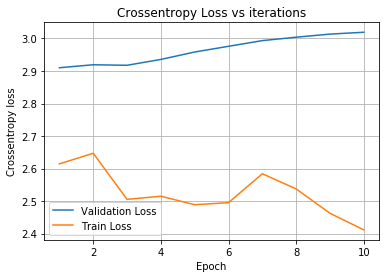

In [46]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)
plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

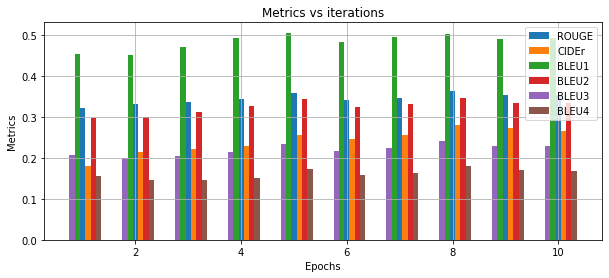

In [113]:
x = np.arange(len(loss_val_per_epoch)) +1 # the label locations
width = 0.1  # the width of the bars
#labels = ['ROUGE', 'CIDEr', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']
fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(x, results['rouge'], width, label='ROUGE')
rects2 = ax.bar(x + width, results['cider'], width, label='CIDEr')
rects3 = ax.bar(x - width, [w[0] for w in results['bleu']], width, label='BLEU1')
rects4 = ax.bar(x + 2*width, [w[1] for w in results['bleu']], width, label='BLEU2')
rects5 = ax.bar(x - 2*width, [w[2] for w in results['bleu']], width, label='BLEU3')
rects6 = ax.bar(x + 3*width, [w[3] for w in results['bleu']], width, label='BLEU4')


ax.set_ylabel('Metrics')
ax.set_xlabel('Epochs')
ax.set_title('Metrics vs iterations')
ax.legend()
ax.grid()

In [49]:
loss_val = np.load('output_tr_3/loss_valtr3.npy')
loss_train = np.load('output_tr_3/loss_traintr3.npy')

loss_val2 = np.load('output_tr_3/loss_val11tr3.npy')
loss_train2 = np.load('output_tr_3/loss_train11tr3.npy')

loss_val_per_epoch = np.mean(loss_val.reshape(10, len(loss_val)//10), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(10, len(loss_train)//10)[:, -100:], axis=1)

loss_val_per_epoch2 = np.mean(loss_val2.reshape(10, len(loss_val2)//10), axis=1)
loss_train_per_epoch2 = np.mean(loss_train2.reshape(10, len(loss_train2)//10)[:, -100:], axis=1)


loss_val_per_epoch  = np.concatenate((loss_val_per_epoch, loss_val_per_epoch2), axis=0)
loss_train_per_epoch  = np.concatenate((loss_train_per_epoch, loss_train_per_epoch2), axis=0)

with open('output/resultstr3.json', 'r') as f:
    results = json.load(f)



Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

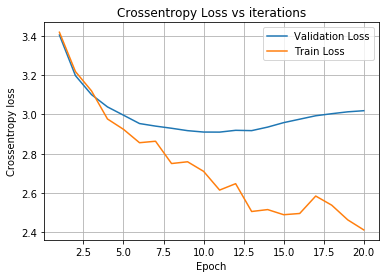

In [50]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)

plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

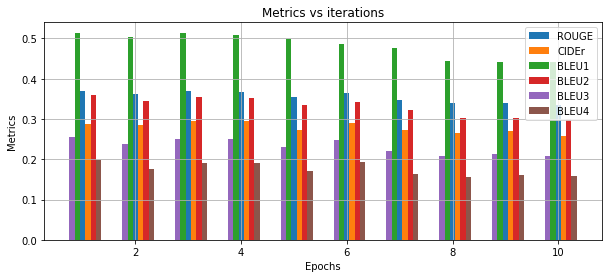

In [35]:
x = np.arange(10) +1 # the label locations
width = 0.1  # the width of the bars
#labels = ['ROUGE', 'CIDEr', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']
fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(x, results['rouge'], width, label='ROUGE')
rects2 = ax.bar(x + width, results['cider'], width, label='CIDEr')
rects3 = ax.bar(x - width, [w[0] for w in results['bleu']], width, label='BLEU1')
rects4 = ax.bar(x + 2*width, [w[1] for w in results['bleu']], width, label='BLEU2')
rects5 = ax.bar(x - 2*width, [w[2] for w in results['bleu']], width, label='BLEU3')
rects6 = ax.bar(x + 3*width, [w[3] for w in results['bleu']], width, label='BLEU4')


ax.set_ylabel('Metrics')
ax.set_xlabel('Epochs')
ax.set_title('Metrics vs iterations')
ax.legend()
ax.grid()

In [36]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output_tr_3/predicted_tr3_11.json'

Namespace(predict_path='output_tr_3/predicted_tr3_11.json', target_path='data/val.json')
{'testlen': 80531, 'reflen': 78792, 'guess': [80531, 72781, 65031, 57281], 'correct': [41358, 18245, 8524, 5149]}
ratio: 1.0220707686059367
bleu = [0.5135662043188274, 0.35880719491343943, 0.2564966899314698, 0.19735103067989038]
cider = 0.288791497226044
rouge = 0.37053197327437726


In [37]:
loss_val = np.load('output_tr4/loss_valtr4.npy')
loss_train = np.load('output_tr4/loss_traintr4.npy')

loss_val2 = np.load('output_tr4/loss_val11tr4.npy')
loss_train2 = np.load('output_tr4/loss_train11tr4.npy')

with open('output_tr4/results11tr4.json', 'r') as f:
    results = json.load(f)

los_val = np.concatenate((loss_val, loss_val2), axis=0)
loss_train = np.concatenate((loss_train, loss_train2), axis=0)
                               
loss_val_per_epoch = np.mean(loss_val.reshape(20, len(loss_val)//20), axis=1)
loss_train_per_epoch = np.mean(loss_train.reshape(20, len(loss_train)//20)[:, -100:], axis=1)



Text(0.5, 1.0, 'Crossentropy Loss vs iterations')

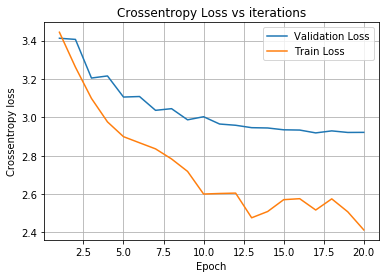

In [21]:
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_val_per_epoch)
plt.plot(range(1, len(loss_val_per_epoch)+1), loss_train_per_epoch)

plt.grid()
plt.legend(['Validation Loss', 'Train Loss'])
plt.ylabel('Crossentropy loss')
plt.xlabel('Epoch')
plt.title('Crossentropy Loss vs iterations')

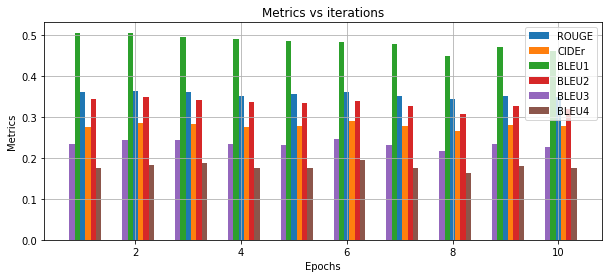

In [38]:
x = np.arange(10) +1 # the label locations
width = 0.1  # the width of the bars
#labels = ['ROUGE', 'CIDEr', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']
fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(x, results['rouge'], width, label='ROUGE')
rects2 = ax.bar(x + width, results['cider'], width, label='CIDEr')
rects3 = ax.bar(x - width, [w[0] for w in results['bleu']], width, label='BLEU1')
rects4 = ax.bar(x + 2*width, [w[1] for w in results['bleu']], width, label='BLEU2')
rects5 = ax.bar(x - 2*width, [w[2] for w in results['bleu']], width, label='BLEU3')
rects6 = ax.bar(x + 3*width, [w[3] for w in results['bleu']], width, label='BLEU4')


ax.set_ylabel('Metrics')
ax.set_xlabel('Epochs')
ax.set_title('Metrics vs iterations')
ax.legend()
ax.grid()

In [28]:
%run evaluate.py --target_path 'data/val.json' --predict_path 'output_tr4/predicted_tr4_12.json'

Namespace(predict_path='output_tr4/predicted_tr4_12.json', target_path='data/val.json')
{'testlen': 84196, 'reflen': 81422, 'guess': [84196, 76446, 68696, 60946], 'correct': [42605, 18392, 8134, 4800]}
ratio: 1.0340694161283064
bleu = [0.5060216637369886, 0.34891661552139563, 0.2433727821593688, 0.1835599846255859]
cider = 0.28535337118863624
rouge = 0.363630692052426


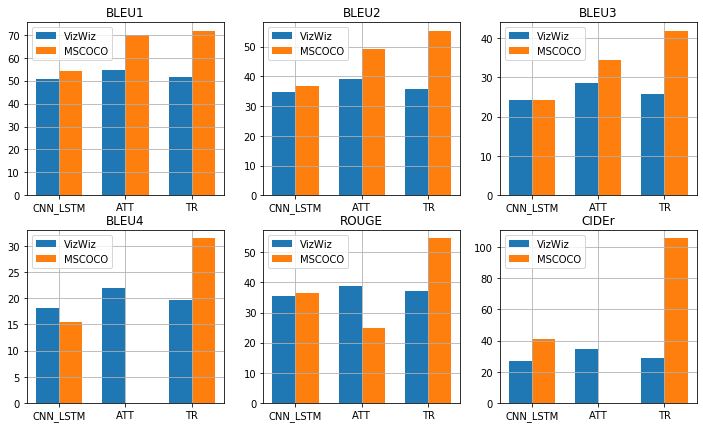

In [56]:
labels = ['CNN_LSTM', 'ATT', 'TR']


fig, axs = plt.subplots(2, 3, figsize=(12, 7))#, sharex=True)

x = np.arange(len(labels))# the label locations
width = 0.35  # the width of the bars
#labels = ['ROUGE', 'CIDEr', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']

l1=axs[0,0].bar(x - width/2, [50.9, 54.6, 51.4], width, label='VizWiz',color='C0' )
l2=axs[0,0].bar(x + width/2, [54.2,70.1,71.8] , width, label='MSCOCO', color = 'C1')
axs[0,0].set_xticks(x)
axs[0,0].set_xticklabels(labels)
axs[0,0].legend()
axs[0,0].set_title('BLEU1')
axs[0,0].grid()

l3=axs[0,1].bar(x - width/2, [34.8, 39.2, 35.9], width, label='VizWiz', color='C0')
l4=axs[0,1].bar(x + width/2, [36.8, 49.2, 55.4] , width, label='MSCOCO',color='C1')
axs[0,1].set_xticks(x)
axs[0,1].set_xticklabels(labels)
axs[0,1].set_title('BLEU2')
axs[0,1].legend()
axs[0,1].grid()


l5=axs[0,2].bar(x - width/2, [24.1, 28.5, 25.7], width, label='VizWiz', color='C0')
l6=axs[0,2].bar(x + width/2, [24.1, 34.4, 41.8] , width, label='MSCOCO',color='C1')
axs[0,2].set_xticks(x)
axs[0,2].set_xticklabels(labels)
axs[0,2].set_title('BLEU3')
axs[0,2].legend()
axs[0,2].grid()

l7=axs[1,0].bar(x - width/2, [18.1, 21.9, 19.7], width, label='VizWiz', color='C0')
l8=axs[1,0].bar(x + width/2, [15.5, 0, 31.5] , width, label='MSCOCO',color='C1')
axs[1,0].set_xticks(x)
axs[1,0].set_xticklabels(labels)
axs[1,0].set_title('BLEU4')
axs[1,0].legend()
axs[1,0].grid()

l9=axs[1,1].bar(x - width/2, [35.5, 38.7, 37.1], width, label='VizWiz', color='C0')
l10=axs[1,1].bar(x + width/2, [36.6, 24.8, 54.7] , width, label='MSCOCO',color='C1')
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(labels)
axs[1,1].set_title('ROUGE')
axs[1,1].legend()
axs[1,1].grid()

l11=axs[1,2].bar(x - width/2, [26.9, 34.7, 28.9], width, label='VizWiz', color='C0')
l12=axs[1,2].bar(x + width/2, [41.2, 0, 105.8] , width, label='MSCOCO',color='C1')
axs[1,2].set_xticks(x)
axs[1,2].set_xticklabels(labels)
axs[1,2].set_title('CIDEr')
axs[1,2].legend()
axs[1,2].grid()


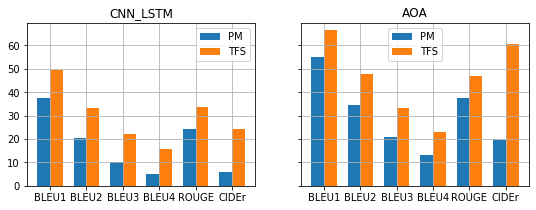

In [37]:
labels = [ 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4', 'ROUGE', 'CIDEr']

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)#, sharex=True)

x = np.arange(len(labels))# the label locations
width = 0.35  # the width of the bars


l1=axs[0].bar(x - width/2, [37.4, 20.6, 10.0, 5.0, 24.2, 6.1], width, label='PM',color='C0' )
l2=axs[0].bar(x + width/2, [49.3, 33.1, 22.0, 15.9, 33.9, 24.3] , width, label='TFS', color = 'C1')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)
axs[0].legend()
axs[0].set_title('CNN_LSTM')
axs[0].grid()

l3=axs[1].bar(x - width/2, [54.9, 34.7, 21.0, 13.2, 37.6, 19.4], width, label='PM', color='C0')
l4=axs[1].bar(x + width/2, [66.4, 47.9, 33.4, 23.2, 47.1, 60.5] , width, label='TFS',color='C1')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)
axs[1].set_title('AOA')
axs[1].legend()
axs[1].grid()